In [1]:
# load useful packages
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import s3fs
%matplotlib inline

import cartopy as cy
import cartopy.crs as ccrs
from matplotlib.colors import LogNorm

In [2]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [3]:
remote_files = 's3://escience2022/Ada/monthly/tos_Omon_NorESM2-LM_omip1_r1i1p1f1_gn_20*.nc'
remote_files = s3.glob(remote_files)

In [4]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(source_id=['NorESM2-LM'], activity_id = ['CMIP'], experiment_id=['piControl'], table_id=['Ofx'], variable_id=['areacello'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/piControl...,NaN,20210118


In [5]:
ds_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [6]:
areacello = ds_dict[list(ds_dict.keys())[0]]

In [7]:
areacello = areacello.squeeze()

In [8]:
BSarea = areacello.areacello.where(areacello.latitude>66)

In [9]:
#1900 
R_fSIi='s3://escience2022/Ada/monthly/siconc_SImon_NorESM2-LM_omip1_r1i1p1f1_gn_19*.nc'
R_fSIi=s3.glob(R_fSIi)

#2000
R_fSI='s3://escience2022/Ada/monthly/siconc_SImon_NorESM2-LM_omip1_r1i1p1f1_gn_20*.nc'
R_fSI=s3.glob(R_fSI)

In [10]:
#1900
fileset = [s3.open(file) for file in R_fSIi]
dSIi = xr.open_mfdataset(fileset, combine='by_coords')
#2000
fileset = [s3.open(file) for file in R_fSI]
dSI = xr.open_mfdataset(fileset, combine='by_coords')

In [11]:
d20= dSI.sel(time=slice('2000-01-01','2020-12-01')).groupby('time.season').mean(dim='time').squeeze()
d20 =d20.where((d20.latitude>66))
d19 = dSIi.sel(time=slice('1900-01-01','1920-12-01')).groupby('time.season').mean(dim='time').squeeze()

In [24]:
season_length = dSIi.time.dt.days_in_month
d19 = dSIi.sel(time=slice('1900-01-01','1920-12-01')).groupby('time.month').mean(dim='time').squeeze()


/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


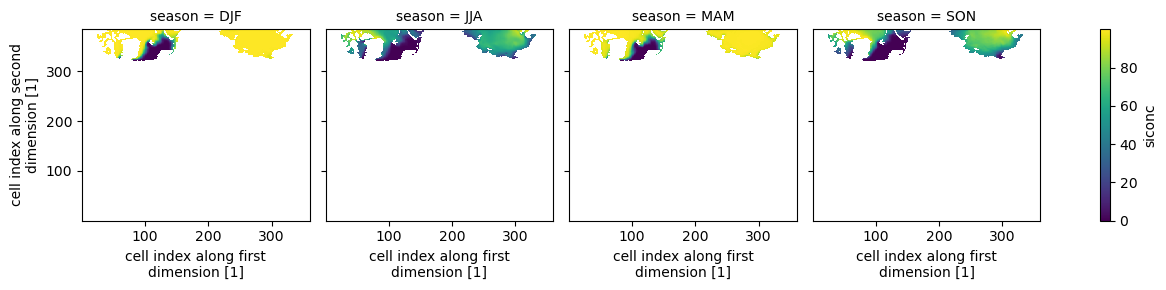

In [13]:
#d19['siconc'].plot(col='season')
d20['siconc'].plot(col='season')                      

In [14]:
import xesmf as xe

In [15]:
ds_out = xe.util.grid_global(1, 1)

In [16]:
dss_season19['lat'] = BSarea['latitude']
dss_season19['lon'] = BSarea['longitude']

NameError: name 'dss_season19' is not defined

In [17]:
regridder = xe.Regridder(d19, ds_out, 'bilinear')

In [18]:
dr_out = regridder(d19['siconc'])

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,


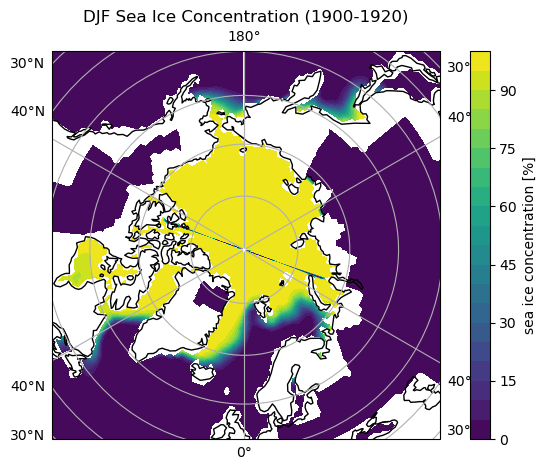

In [19]:
f, ax = plt.subplots( subplot_kw=dict(projection=ccrs.Orthographic(0,90)))


W = ax.contourf(dr_out.lon,
              dr_out.lat,
              dr_out.isel(season=0),
              levels=np.arange(0, 101, 5),
              transform=ccrs.PlateCarree(),
               )
               #col='season') 
    
f.colorbar(W , label='sea ice concentration [%]')
ax.set_extent([-180, 180, 90, 50], ccrs.PlateCarree())
ax.set_title('DJF Sea Ice Concentration (1900-1920)')
ax.gridlines(draw_labels=True) 
ax.coastlines()
f.tight_layout()    

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregations.py:258: RuntimeWarning: invalid value encountered in divide
  finalize=lambda sum_, count: sum_ / count,
/tmp/ipykernel_338/177610760.py:45: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  f.colorbar(W , label='sea ice concentration [%]') #, ax=ax1)


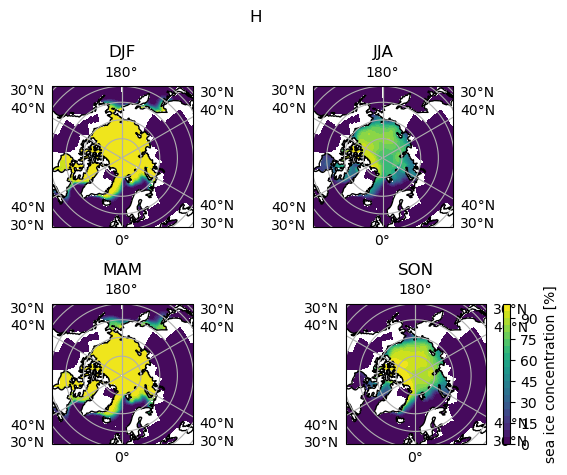

In [20]:
f, ax = plt.subplots(2,2 ,subplot_kw=dict(projection=ccrs.Orthographic(0,90)))
axs=ax.flatten()

ax1=axs[0] 
ax2=axs[1]
ax3=axs[2]
ax4=axs[3]



W = ax1.contourf(dr_out.lon,
              dr_out.lat,
              dr_out.isel(season=0),
              levels=np.arange(0, 101, 5),
              transform=ccrs.PlateCarree(),
              )
               #col='season') 
    
S = ax2.contourf(dr_out.lon,
              dr_out.lat,
              dr_out.isel(season=1),
              levels=np.arange(0, 101, 5),
              transform=ccrs.PlateCarree(),
             )
               #col='season')   

Sp = ax3.contourf(dr_out.lon,
              dr_out.lat,
              dr_out.isel(season=2),
              levels=np.arange(0, 101, 5),
              transform=ccrs.PlateCarree(),
               )
               #col='season')     
    
A = ax4.contourf(dr_out.lon,
              dr_out.lat,
              dr_out.isel(season=3),
              levels=np.arange(0, 101, 5),
              transform=ccrs.PlateCarree(),
                )
               #col='season')      

f.suptitle('H')    
  
f.colorbar(W , label='sea ice concentration [%]') #, ax=ax1)
ax1.set_extent([-180, 180, 90, 50], ccrs.PlateCarree())
ax1.set_title('DJF')
ax1.gridlines(draw_labels=True) 
ax1.coastlines()
plt.tight_layout()

#plt.colorbar(S , label='sea ice concentration [%]') #, ax=ax2)
ax2.set_extent([-180, 180, 90, 50], ccrs.PlateCarree())
ax2.set_title('JJA')
ax2.gridlines(draw_labels=True) 
ax2.coastlines()
plt.tight_layout()

#plt.colorbar(Sp , label='sea ice concentration [%]') #, ax=ax3)
ax3.set_extent([-180, 180, 90, 50], ccrs.PlateCarree())
ax3.set_title('MAM')
ax3.gridlines(draw_labels=True) 
ax3.coastlines()
plt.tight_layout()

#plt.colorbar(A , label='sea ice concentration [%]') #, ax=ax4)
ax4.set_extent([-180, 180, 90, 50], ccrs.PlateCarree())
ax4.set_title('SON')
ax4.gridlines(draw_labels=True) 
ax4.coastlines()
plt.tight_layout()